# AUTOENCODER EXPERIMENT

This notebook details the process of creating a synthetic dataset for cube localization using sensor data, defining and training autoencoder models (U-Net and U-Net++ variants), and evaluating their performance.

## 1. Setup and Imports

Import necessary libraries for data generation, manipulation, model building, and visualization.

In [1]:
import os
import random
import zipfile
import pickle
import time
from pathlib import Path
import io  

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from scipy.signal import spectrogram
import scipy.signal
import torchinfo
from torchinfo import summary

## 2. Synthetic Dataset Generation

We generate a synthetic dataset simulating sensor readings based on the position of a cube within a defined box.

### 2.1. Parameters and Directories

Define constants used for dataset generation.

In [2]:
# Dataset Configuration
BOX_SIZE = 100  # Size of the square area
CUBE_SIZE = 15  # Size of the cube
SENSOR_POSITIONS = [
    (0, 0),
    (0, BOX_SIZE),
    (BOX_SIZE, 0),
    (BOX_SIZE, BOX_SIZE)
]  # Coordinates of the four sensors
VALID_POSITIONS = range(
    CUBE_SIZE // 2, BOX_SIZE - CUBE_SIZE // 2 + 1
)  # Range of valid center positions for the cube

# Signal Parameters
SIGNAL_LENGTH = 2048  # Number of samples per signal
SAMPLING_RATE = 1000  # Samples per second (Hz)

# Spectrogram Parameters (defaults for generate_spectrogram function)
NPERSEG = 128
NOVERLAP = 96
NFFT = 256

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

### 2.2. Signal and Spectrogram Generation Functions

Define functions to generate synthetic acceleration signals, compute spectrograms, and create ground truth position images.

In [3]:
def generate_acceleration_signals(cube_x, cube_y):
    """
    Generates diverse synthetic acceleration signals for four sensors based on
    cube position.

    Introduces variations based on position, distance, and random factors
    to create complex and distinct signals for different locations.

    Args:
        cube_x (int): X-coordinate of the cube's center.
        cube_y (int): Y-coordinate of the cube's center.

    Returns:
        list[np.ndarray]: A list containing four numpy arrays, each representing
                          the acceleration signal for one sensor.
    """
    time_vector = np.linspace(0, (SIGNAL_LENGTH - 1) / SAMPLING_RATE, SIGNAL_LENGTH)
    signals = []

    # Create a unique random generator for this specific position
    position_seed = int(cube_x * 10000 + cube_y * 100)
    rng = np.random.default_rng(seed=position_seed)

    # Generate random characteristics unique to this position
    pattern_type = rng.integers(0, 4)  # Choose one of four signal patterns
    base_amplitude = rng.uniform(0.5, 2.0)
    phase_shift = rng.uniform(0, 2 * np.pi)

    for sensor_idx, (sx, sy) in enumerate(SENSOR_POSITIONS):
        distance = np.hypot(cube_x - sx, cube_y - sy)

        # Create a unique random generator for this sensor at this position
        sensor_seed = position_seed + sensor_idx
        sensor_rng = np.random.default_rng(seed=sensor_seed)

        # --- Signal Characteristic Modifications ---
        # Vary base frequency based on position
        base_freq = 5 + 15 * (cube_x / BOX_SIZE) + 10 * (cube_y / BOX_SIZE)

        # Apply distance-based attenuation and time delay
        attenuation = 1.0 / (1.0 + distance * 0.2)
        time_delay = distance * 0.01 # Simplified delay model
        delayed_time = time_vector - time_delay
        # Ensure delayed_time indices are valid (simple wrap-around for illustration)
        # A more realistic approach might involve padding or handling edge cases.
        valid_indices = np.where(delayed_time >= 0)[0]
        delayed_time = delayed_time[valid_indices]
        effective_length = len(delayed_time)

        # --- Generate Different Signal Patterns ---
        signal = np.zeros(SIGNAL_LENGTH) # Initialize signal array

        if effective_length > 0: # Check if there's any signal after delay
            current_signal = np.zeros(effective_length)
            if pattern_type == 0:
                # Chirp signal (frequency sweep)
                current_signal = base_amplitude * attenuation * np.sin(
                    2 * np.pi * base_freq * delayed_time +
                    5 * np.pi * delayed_time**2 +
                    phase_shift
                )
            elif pattern_type == 1:
                # AM modulated signal
                carrier = np.sin(2 * np.pi * base_freq * delayed_time + phase_shift)
                modulator = 0.5 + 0.5 * np.sin(2 * np.pi * 2 * delayed_time)
                current_signal = base_amplitude * attenuation * carrier * modulator
            elif pattern_type == 2:
                # Complex harmonic mixture
                for harmonic_idx, harmonic in enumerate([1.0, 1.5, 2.2, 3.7]):
                    harmonic_amp = base_amplitude * attenuation * (0.7 ** harmonic_idx)
                    current_signal += harmonic_amp * np.sin(
                        2 * np.pi * harmonic * base_freq * delayed_time +
                        phase_shift + harmonic_idx * np.pi / 4
                    )
            else: # pattern_type == 3
                # Pulse train with varying width
                pulse_freq = base_freq / 5
                pulse_width = 0.2 + 0.3 * (cube_x / BOX_SIZE) # Duty cycle varies
                current_signal = base_amplitude * attenuation * scipy.signal.square(
                    2 * np.pi * pulse_freq * delayed_time + phase_shift,
                    duty=pulse_width
                )

            # Place the generated signal segment into the full signal array
            signal[valid_indices] = current_signal


        # Add sudden transient events if sensor is close to the cube
        if distance < 10:
            impulse_time_idx = int(SIGNAL_LENGTH * (0.3 + 0.4 * (cube_y / BOX_SIZE)))
            impulse_width = int(SIGNAL_LENGTH * 0.05)
            impulse_start = max(0, impulse_time_idx - impulse_width // 2)
            impulse_end = min(SIGNAL_LENGTH, impulse_time_idx + impulse_width // 2)
            actual_width = impulse_end - impulse_start
            if actual_width > 0:
                 signal[impulse_start:impulse_end] += (
                     2.0 * attenuation * np.hamming(actual_width)
                 )

        # --- Add Position-Dependent Noise ---
        noise_level = 0.05 + 0.1 * (cube_x / BOX_SIZE)
        raw_noise = sensor_rng.normal(0, noise_level, SIGNAL_LENGTH)

        # Apply a position-dependent low-pass filter to the noise
        # Filter cutoff frequency varies with the cube's y-position
        nyquist = 0.5 * SAMPLING_RATE
        cutoff_norm = (0.1 + 0.8 * (cube_y / BOX_SIZE)) # Normalized cutoff freq [0, 1]
        # Ensure cutoff is within valid range (avoiding 0 and 1)
        cutoff_norm = np.clip(cutoff_norm, 0.01, 0.99)

        # Design a Butterworth filter (order 2)
        try:
            b, a = scipy.signal.butter(2, cutoff_norm, btype='lowpass')
            filtered_noise = scipy.signal.filtfilt(b, a, raw_noise)
        except ValueError as e:
            print(f"Warning: Butter filter creation failed (cutoff={cutoff_norm}). Using raw noise. Error: {e}")
            filtered_noise = raw_noise


        signals.append(signal + filtered_noise)

    return signals


def generate_spectrogram(signal):
    """
    Generates a spectrogram from a time-domain signal with enhanced processing.

    Args:
        signal (np.ndarray): The input acceleration signal.

    Returns:
        np.ndarray: A 128x128 grayscale spectrogram image (uint8).
    """
    f, t, Sxx = spectrogram(
        signal,
        fs=SAMPLING_RATE,
        nperseg=NPERSEG,
        noverlap=NOVERLAP,
        nfft=NFFT,
        scaling='spectrum' # Use 'spectrum' (Sxx units V**2/Hz) or 'density'
    )

    # --- Spectrogram Enhancement ---
    # Use magnitude or power spectrum (sqrt(Sxx) or Sxx)
    # Applying sqrt helps compress high values, similar to log but less aggressive
    Sxx_processed = np.sqrt(Sxx)

    # Avoid division by zero or log(0)
    Sxx_processed = Sxx_processed / (Sxx_processed.max() + 1e-10)

    # Optional: Gamma correction to adjust brightness/contrast
    Sxx_processed = Sxx_processed ** 0.5

    # --- Normalization for Visualization ---
    # Use percentiles to handle outliers and improve dynamic range
    vmin = np.percentile(Sxx_processed, 5)
    vmax = np.percentile(Sxx_processed, 99.9)

    # Clip values to the [vmin, vmax] range and normalize to [0, 1]
    Sxx_norm = np.clip((Sxx_processed - vmin) / (vmax - vmin + 1e-10), 0, 1)

    # --- Resize and Convert ---
    # Resize to the target dimensions using cubic interpolation for smoother results
    Sxx_resized = cv2.resize(
        Sxx_norm,
        (128, 128),
        interpolation=cv2.INTER_CUBIC
    )

    # Scale to [0, 255] and convert to uint8 for image saving
    return (Sxx_resized * 255).astype(np.uint8)


def generate_ground_truth(cube_x, cube_y):
    """
    Generates a binary ground truth image indicating the cube's position.

    Args:
        cube_x (int): X-coordinate of the cube's center.
        cube_y (int): Y-coordinate of the cube's center.

    Returns:
        np.ndarray: A BOX_SIZE x BOX_SIZE binary image (uint8) with a white
                    square representing the cube.
    """
    img = np.zeros((BOX_SIZE, BOX_SIZE), dtype=np.uint8)

    # Calculate cube boundaries, ensuring they stay within the box
    half_size = CUBE_SIZE // 2
    x_start = max(0, cube_x - half_size)
    x_end = min(BOX_SIZE, cube_x + half_size + (CUBE_SIZE % 2)) # Add 1 if odd size
    y_start = max(0, cube_y - half_size)
    y_end = min(BOX_SIZE, cube_y + half_size + (CUBE_SIZE % 2))

    # Draw the white cube
    img[y_start:y_end, x_start:x_end] = 255

    return img


def save_samples(positions, dataset_root, split_name):
    """
    Generates and saves spectrograms and ground truth images for given positions.

    Args:
        positions (list[tuple]): List of (x, y) coordinates for the samples.
        dataset_root (str or Path): The root directory of the dataset.
        split_name (str): The name of the split ('train' or 'test').
    """
    spec_path = Path(dataset_root) / split_name / "spectrograms"
    gt_path = Path(dataset_root) / split_name / "ground_truth"
    spec_path.mkdir(parents=True, exist_ok=True)
    gt_path.mkdir(parents=True, exist_ok=True)

    num_positions = len(positions)
    start_time = time.time()

    for i, (x, y) in enumerate(positions):
        # Generate data for the current position
        signals = generate_acceleration_signals(x, y)
        gt_image = generate_ground_truth(x, y)

        # Save spectrograms for each sensor
        for sensor_idx, signal in enumerate(signals):
            spec = generate_spectrogram(signal)
            filename = f"{x:03d}_{y:03d}_{sensor_idx}.jpg"
            cv2.imwrite(str(spec_path / filename), spec)

        # Save ground truth image
        gt_filename = f"{x:03d}_{y:03d}.jpg"
        cv2.imwrite(str(gt_path / gt_filename), gt_image)

        # Print progress
        if (i + 1) % 50 == 0 or (i + 1) == num_positions:
            elapsed = time.time() - start_time
            print(f"  Saved {i+1}/{num_positions} samples for {split_name} ({elapsed:.2f}s elapsed)")

    print(f"Finished saving samples for {split_name}.")


def zip_dataset(dataset_name, zip_filename):
    """
    Compresses the generated dataset directory into a zip file.

    Args:
        dataset_name (str or Path): The name of the dataset directory.
        zip_filename (str or Path): The desired name for the output zip file.
    """
    print(f"Zipping dataset '{dataset_name}' into '{zip_filename}'...")
    start_time = time.time()
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        root_dir = Path(dataset_name)
        for file_path in root_dir.rglob('*'):
            if file_path.is_file():
                arcname = file_path.relative_to(root_dir)
                zipf.write(file_path, arcname)
    elapsed = time.time() - start_time
    print(f"Dataset successfully zipped in {elapsed:.2f} seconds.")

### 2.3. Generate a Smaller Dataset Example

Create a dataset with a limited number of samples for quicker experimentation.

In [4]:
# Configuration for the small dataset
DATASET_NAME_SMALL = "cube_dataset_500_examples"
ZIP_FILENAME_SMALL = f"{DATASET_NAME_SMALL}.zip"
TOTAL_SAMPLES_SMALL = 500
TRAIN_RATIO_SMALL = 0.8

# Reset seed specifically for dataset generation if needed,
# otherwise uses the global SEED set earlier.
# np.random.seed(SEED)
# random.seed(SEED)


def create_small_dataset(dataset_name, total_samples=500, train_ratio=0.8):
    """
    Creates a smaller dataset with paired spectrograms and ground truth images.

    Args:
        dataset_name (str or Path): The root directory name for the dataset.
        total_samples (int): Total number of unique (x, y) positions to generate.
        train_ratio (float): Proportion of samples to allocate to the training set.

    Returns:
        tuple: Contains two lists:
            - train_positions (list[tuple]): (x, y) positions for the training set.
            - test_positions (list[tuple]): (x, y) positions for the test set.
    """
    dataset_path = Path(dataset_name)
    print(f"Creating dataset '{dataset_name}' with {total_samples} total samples...")

    # Ensure base directories exist (save_samples will create subdirs)
    (dataset_path / "train").mkdir(parents=True, exist_ok=True)
    (dataset_path / "test").mkdir(parents=True, exist_ok=True)

    # --- Generate unique random positions ---
    all_positions = set()
    while len(all_positions) < total_samples:
        x = random.choice(VALID_POSITIONS)
        y = random.choice(VALID_POSITIONS)
        all_positions.add((x, y))

    all_positions_list = list(all_positions)
    random.shuffle(all_positions_list) # Shuffle before splitting

    # --- Split into train and test sets ---
    train_size = int(total_samples * train_ratio)
    test_size = total_samples - train_size

    train_positions = all_positions_list[:train_size]
    test_positions = all_positions_list[train_size:]

    print(f"Generated {len(train_positions)} training and {len(test_positions)} testing positions.")

    # --- Generate and save samples ---
    print("Generating training samples...")
    save_samples(train_positions, dataset_path, "train")

    print("Generating testing samples...")
    save_samples(test_positions, dataset_path, "test")

    print("-" * 30)
    print(f"Dataset creation complete. {train_size} training, {test_size} testing samples saved.")
    print("-" * 30)
    return train_positions, test_positions

# Generate the small dataset
train_pos, test_pos = create_small_dataset(
    DATASET_NAME_SMALL,
    TOTAL_SAMPLES_SMALL,
    TRAIN_RATIO_SMALL
)

# Optional: Zip the created dataset
# zip_dataset(DATASET_NAME_SMALL, ZIP_FILENAME_SMALL)

Creating dataset 'cube_dataset_500_examples' with 500 total samples...
Generated 400 training and 100 testing positions.
Generating training samples...
  Saved 50/400 samples for train (0.81s elapsed)
  Saved 100/400 samples for train (1.78s elapsed)
  Saved 150/400 samples for train (3.27s elapsed)
  Saved 200/400 samples for train (4.40s elapsed)
  Saved 250/400 samples for train (5.55s elapsed)
  Saved 300/400 samples for train (6.52s elapsed)
  Saved 350/400 samples for train (7.46s elapsed)
  Saved 400/400 samples for train (8.35s elapsed)
Finished saving samples for train.
Generating testing samples...
  Saved 50/100 samples for test (0.77s elapsed)
  Saved 100/100 samples for test (1.72s elapsed)
Finished saving samples for test.
------------------------------
Dataset creation complete. 400 training, 100 testing samples saved.
------------------------------


## 3. Data Loading

Define a PyTorch Dataset and DataLoader to efficiently load and preprocess the generated data.

### 3.1. Custom Dataset Class

In [5]:
# Reset seed for dataloader operations if needed (shuffling)
# SEED_DATALOADER = 32 # Or use the global SEED
# np.random.seed(SEED_DATALOADER)
# random.seed(SEED_DATALOADER)
# torch.manual_seed(SEED_DATALOADER)

class CubeDataset(Dataset):
    """
    PyTorch Dataset for loading cube localization data (spectrograms and ground truth).

    Handles loading images, applying transformations, and returning pairs of
    stacked spectrogram tensors and ground truth tensors.
    """

    def __init__(self, root_dir, split='train', spec_transform=None, gt_transform=None):
        """
        Initializes the CubeDataset.

        Args:
            root_dir (str or Path): Root directory of the dataset
                                    (e.g., 'cube_dataset_500_examples').
            split (str): The dataset split to load ('train' or 'test').
            spec_transform (callable, optional): Transformations to apply to spectrograms.
                                                 Defaults to resize and ToTensor.
            gt_transform (callable, optional): Transformations to apply to ground truth masks.
                                               Defaults to resize and ToTensor.
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.spec_dir = self.root_dir / split / "spectrograms"
        self.gt_dir = self.root_dir / split / "ground_truth"

        # --- Define default transforms if none are provided ---
        if spec_transform is None:
            self.transform_spectrogram = transforms.Compose([
                transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.ToTensor() # Scales images from [0, 255] to [0, 1]
            ])
        else:
            self.transform_spectrogram = spec_transform

        if gt_transform is None:
            self.transform_gt = transforms.Compose([
                transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.NEAREST), # Use NEAREST for masks
                transforms.ToTensor() # Scales images from [0, 255] to [0, 1]
            ])
        else:
            self.transform_gt = gt_transform

        # --- List ground truth files (defines the dataset samples) ---
        # Ensure files are sorted for consistent order if reproducibility is critical
        self.gt_files = sorted([f for f in os.listdir(self.gt_dir) if f.endswith('.jpg')])
        if not self.gt_files:
            raise FileNotFoundError(f"No ground truth files found in {self.gt_dir}")

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.gt_files)

    def __getitem__(self, idx):
        """
        Loads and returns a single sample (spectrograms stack, ground truth) from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing:
                - specs_tensor (torch.Tensor): Stacked spectrograms [4, C, H, W] (C=1).
                - gt_tensor (torch.Tensor): Ground truth mask [1, H', W'].
        """
        # --- Load Ground Truth ---
        gt_filename = self.gt_files[idx]
        gt_path = self.gt_dir / gt_filename

        # Extract position (x, y) from the filename (e.g., "012_034.jpg")
        try:
            x_str, y_str = gt_filename.split('.')[0].split('_')
            x, y = int(x_str), int(y_str)
        except ValueError:
            raise ValueError(f"Could not parse position from filename: {gt_filename}")

        # Load image using PIL (robust loading)
        try:
            gt_image = Image.open(gt_path).convert('L') # Convert to grayscale
        except FileNotFoundError:
            raise FileNotFoundError(f"Ground truth file not found: {gt_path}")
        except Exception as e:
            raise IOError(f"Error loading ground truth image {gt_path}: {e}")

        # Apply transformations
        gt_tensor = self.transform_gt(gt_image)

        # --- Load Corresponding Spectrograms ---
        specs_tensors_list = []
        for sensor_idx in range(len(SENSOR_POSITIONS)): # Typically 4 sensors
            spec_filename = f"{x:03d}_{y:03d}_{sensor_idx}.jpg"
            spec_path = self.spec_dir / spec_filename

            try:
                spec_image = Image.open(spec_path).convert('L') # Grayscale
            except FileNotFoundError:
                # Handle cases where a specific sensor's spectrogram might be missing
                print(f"Warning: Spectrogram file not found: {spec_path}. Skipping sample {idx}.")
                # Option 1: Return None or raise error to filter in DataLoader collate_fn
                # Option 2: Return a dummy tensor (less ideal)
                # For simplicity here, we might raise an error or return None
                # depending on how the training loop handles it. Let's raise for now.
                raise FileNotFoundError(f"Spectrogram file not found: {spec_path}")
            except Exception as e:
                 raise IOError(f"Error loading spectrogram image {spec_path}: {e}")

            # Apply transformations
            spec_tensor = self.transform_spectrogram(spec_image)
            specs_tensors_list.append(spec_tensor)

        # Stack spectrograms along a new dimension (channel dimension becomes 4)
        # Resulting shape: [num_sensors, height, width] - needs adjustment later
        # If ToTensor already added channel dim -> [num_sensors, 1, H, W]
        # Let's assume ToTensor makes it [1, H, W], stack creates [4, 1, H, W]
        if specs_tensors_list[0].dim() == 3: # Check if channel dim exists (e.g., [1, H, W])
             specs_tensor = torch.stack(specs_tensors_list) # Shape: [4, 1, H, W]
        else: # If ToTensor resulted in [H, W]
             specs_tensor = torch.stack(specs_tensors_list).unsqueeze(1) # Shape: [4, 1, H, W]


        # Squeeze out the channel dimension from stacking if necessary,
        # Models expect [Batch, Channels, H, W], where Channels = 4 here.
        # Final desired input shape for model: [Batch, 4, H, W]
        # Current shape from stack: [4, 1, H, W]
        # Need to permute or squeeze/unsqueeze correctly
        specs_tensor = specs_tensor.squeeze(1) # Shape: [4, H, W]

        return specs_tensor, gt_tensor

In [6]:
def create_dataloaders(dataset_name, batch_size=16, num_workers=0):
    """
    Creates PyTorch DataLoaders for the training and testing sets.

    Args:
        dataset_name (str or Path): Name of the dataset directory.
        batch_size (int): Number of samples per batch.
        num_workers (int): Number of subprocesses to use for data loading.
                           0 means data will be loaded in the main process.

    Returns:
        tuple: Contains two DataLoader objects:
            - train_dataloader (DataLoader): DataLoader for the training set.
            - test_dataloader (DataLoader): DataLoader for the test set.
    """
    print(f"\nCreating DataLoaders for dataset '{dataset_name}'...")

    # Create PyTorch datasets with default transforms
    try:
        train_dataset = CubeDataset(dataset_name, 'train')
        test_dataset = CubeDataset(dataset_name, 'test')
    except FileNotFoundError as e:
        print(f"Error creating datasets: {e}")
        print("Please ensure the dataset directory structure is correct:")
        print(f"{dataset_name}/")
        print(f"  ├── train/")
        print(f"  │   ├── spectrograms/")
        print(f"  │   └── ground_truth/")
        print(f"  └── test/")
        print(f"      ├── spectrograms/")
        print(f"      └── ground_truth/")
        return None, None
    except Exception as e:
         print(f"An unexpected error occurred during dataset creation: {e}")
         return None, None


    print(f"Found {len(train_dataset)} training samples and {len(test_dataset)} testing samples.")

    if len(train_dataset) == 0 or len(test_dataset) == 0:
        print("Warning: One or both datasets are empty. Check dataset generation.")
        return None, None

    # --- Create DataLoaders ---
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True, # Shuffle training data each epoch
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False # Faster data transfer to GPU if available
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False, # No need to shuffle test data
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"DataLoaders created with batch size {batch_size}.")
    print("-" * 30)
    return train_dataloader, test_dataloader

# Create dataloaders for the small dataset
train_dataloader_small, test_dataloader_small = create_dataloaders(
    DATASET_NAME_SMALL,
    batch_size=16,
    num_workers=0 # Set to > 0 for parallel loading if beneficial
)


Creating DataLoaders for dataset 'cube_dataset_500_examples'...
Found 400 training samples and 100 testing samples.
DataLoaders created with batch size 16.
------------------------------


## 4. Model Training and Evaluation Utilities

Define functions for the training loop, visualizing model predictions, and plotting loss curves.

### 4.1. Training Loop

In [7]:
def train_model(model: nn.Module,
                train_loader: torch.utils.data.DataLoader,
                test_loader: torch.utils.data.DataLoader,
                num_epochs: int,
                optimizer: torch.optim.Optimizer,
                criterion: nn.Module,
                device: torch.device = None):
    """
    Trains a PyTorch model and evaluates it on a test set.

    Args:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader for the training data.
        test_loader (DataLoader): DataLoader for the testing data.
        num_epochs (int): The number of epochs to train for.
        optimizer (Optimizer): The optimization algorithm.
        criterion (nn.Module): The loss function.
        device (torch.device, optional): The device to train on ('cuda' or 'cpu').
                                         Autodetects if None.

    Returns:
        dict: A dictionary containing training and testing loss history:
              {"train_loss": list[float], "test_loss": list[float]}
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model.to(device)

    results = {"train_loss": [], "test_loss": []}

    print(f"\nStarting training for {num_epochs} epochs...")
    start_time_total = time.time()

    for epoch in range(num_epochs):
        start_time_epoch = time.time()
        model.train()
        running_train_loss = 0.0

        # --- Training Phase ---
        for batch_idx, (spectrograms, ground_truth) in enumerate(train_loader):
            # Spectrograms shape: [Batch, 4, H, W]
            # Ground truth shape: [Batch, 1, H', W']
            spectrograms = spectrograms.to(device)
            spectrograms = spectrograms.squeeze(2)
            ground_truth = ground_truth.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(spectrograms) # Expected output: [Batch, 1, H', W']

            # Calculate loss
            loss = criterion(outputs, ground_truth)

            # Backward pass
            loss.backward()

            # Optimize
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        results["train_loss"].append(avg_train_loss)

        # --- Validation Phase ---
        model.eval()
        running_test_loss = 0.0
        with torch.inference_mode(): # Disable gradient calculation for validation
            for spectrograms, ground_truth in test_loader:
                spectrograms = spectrograms.to(device)
                ground_truth = ground_truth.to(device)

                outputs = model(spectrograms)
                loss = criterion(outputs, ground_truth)
                running_test_loss += loss.item() # Use .item() to get Python number

        avg_test_loss = running_test_loss / len(test_loader)
        results["test_loss"].append(avg_test_loss) # Store test loss as float

        # --- Logging ---
        epoch_time = time.time() - start_time_epoch
        print(f"Epoch [{epoch+1:03d}/{num_epochs:03d}] | "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Test Loss: {avg_test_loss:.6f} | "
              f"Time: {epoch_time:.2f}s")

    total_training_time = time.time() - start_time_total
    print("-" * 30)
    print(f"Training complete! Total time: {total_training_time:.2f}s")
    print(f"Final Train Loss: {results['train_loss'][-1]:.6f}")
    print(f"Final Test Loss: {results['test_loss'][-1]:.6f}")
    print("-" * 30)
    return results

### 4.2. Visualization Functions

In [8]:
def visualize_results(model: nn.Module,
                      test_loader: torch.utils.data.DataLoader,
                      num_examples: int = 5,
                      device: torch.device = None):
    """
    Visualizes model predictions against ground truth for a few test examples.

    Args:
        model (nn.Module): The trained model.
        test_loader (DataLoader): DataLoader for the test set.
        num_examples (int): Maximum number of examples to display.
        device (torch.device, optional): Device to run inference on. Autodetects if None.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nVisualizing results on device: {device}")

    model.to(device)
    model.eval()

    examples_shown = 0
    with torch.inference_mode():
        for spectrograms, ground_truth in test_loader:
            # Move data to the inference device
            spectrograms = spectrograms.to(device)
            # Note: Keep ground_truth on CPU for plotting with matplotlib

            # Get model predictions
            outputs = model(spectrograms)
            outputs = outputs.cpu() # Move predictions to CPU for plotting

            # Iterate through the batch
            for i in range(spectrograms.size(0)):
                if examples_shown >= num_examples:
                    break

                # Prepare data for display
                input_specs = spectrograms[i].cpu().numpy() # Shape [4, H, W]
                gt_mask = ground_truth[i].squeeze().numpy() # Shape [H', W']
                pred_mask = outputs[i].squeeze().numpy()   # Shape [H', W']

                # --- Plotting ---
                fig, axes = plt.subplots(2, 3, figsize=(12, 8))
                fig.suptitle(f"Example {examples_shown + 1}", fontsize=16)

                # Plot input spectrograms
                for j in range(4):
                    row, col = (0, j) if j < 2 else (1, j - 2)
                    ax = axes[row, col]
                    # Use a perceptually uniform colormap like 'viridis' or 'magma'
                    im = ax.imshow(input_specs[j], cmap="magma", aspect='auto')
                    ax.set_title(f"Input Spectrogram {j+1}")
                    ax.axis("off")
                    # fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04) # Optional colorbar

                # Plot Ground Truth
                axes[0, 2].imshow(gt_mask, cmap="gray")
                axes[0, 2].set_title("Ground Truth Mask")
                axes[0, 2].axis("off")

                # Plot Model Output (Prediction)
                im_pred = axes[1, 2].imshow(pred_mask, cmap='gray', vmin=0, vmax=1) # Ensure consistent scale
                axes[1, 2].set_title("Model Output (Prediction)")
                axes[1, 2].axis('off')
                # fig.colorbar(im_pred, ax=axes[1, 2], fraction=0.046, pad=0.04) # Optional colorbar


                plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
                plt.show()

                examples_shown += 1
            if examples_shown >= num_examples:
                break

    print("Visualization complete.")


def plot_loss_curve(model_results: dict, title: str = "Model Loss Curve"):
    """
    Plots the training and testing loss curves from model results.

    Args:
        model_results (dict): Dictionary containing 'train_loss' and 'test_loss' lists.
        title (str): The title for the plot.
    """
    train_loss = model_results.get("train_loss", [])
    test_loss = model_results.get("test_loss", [])

    if not train_loss or not test_loss:
        print("Warning: Loss data missing in model_results. Cannot plot curve.")
        return

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label="Train Loss", marker='o', linestyle='-')
    # Test loss might be stored as tensors, convert to float if necessary
    # test_loss_float = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in test_loss]
    plt.plot(epochs, test_loss, label="Test Loss", marker='x', linestyle='--')

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, step=max(1, len(epochs)//10))) # Adjust tick frequency
    plt.ylim(bottom=0) # Loss should not be negative
    plt.tight_layout()
    plt.show()

## 5. Model Architectures

Define the U-Net and U-Net++ based autoencoder architectures.

### 5.1. `UNetAutoencoder` (Based on `CNNAutoencoder_V4`)
Standard U-Net architecture with skip connections.

In [9]:
class UNetAutoencoder(nn.Module):
    """
    U-Net based Autoencoder for image-to-image translation.

    Takes multi-channel spectrogram input and outputs a single-channel mask.
    Uses skip connections between encoder and decoder paths.
    Input: [B, 4, 128, 128] -> Output: [B, 1, 64, 64]
    """
    def __init__(self, input_channels=4, output_channels=1):
        super().__init__()

        # --- Contracting Path (Encoder) ---
        # Input: [B, 4, 128, 128]
        self.enc_conv0 = self._conv_block(input_channels, 32) # -> [B, 32, 128, 128]
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)   # -> [B, 32, 64, 64]

        self.enc_conv1 = self._conv_block(32, 64)             # -> [B, 64, 64, 64]
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)   # -> [B, 64, 32, 32]

        self.enc_conv2 = self._conv_block(64, 128)            # -> [B, 128, 32, 32]
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)   # -> [B, 128, 16, 16]

        self.enc_conv3 = self._conv_block(128, 256)           # -> [B, 256, 16, 16]
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)   # -> [B, 256, 8, 8]

        self.enc_conv4 = self._conv_block(256, 512)           # -> [B, 512, 8, 8]
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)   # -> [B, 512, 4, 4]

        # --- Bottleneck ---
        self.bottleneck = self._conv_block(512, 1024)         # -> [B, 1024, 4, 4]

        # --- Expansive Path (Decoder) ---
        # Input: [B, 1024, 4, 4]
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # -> [B, 512, 8, 8]
        # Concatenate with enc_conv4 output ([B, 512, 8, 8]) -> [B, 1024, 8, 8]
        self.dec_conv4 = self._conv_block(1024, 512)                          # -> [B, 512, 8, 8]

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # -> [B, 256, 16, 16]
        # Concatenate with enc_conv3 output ([B, 256, 16, 16]) -> [B, 512, 16, 16]
        self.dec_conv3 = self._conv_block(512, 256)                           # -> [B, 256, 16, 16]

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # -> [B, 128, 32, 32]
        # Concatenate with enc_conv2 output ([B, 128, 32, 32]) -> [B, 256, 32, 32]
        self.dec_conv2 = self._conv_block(256, 128)                           # -> [B, 128, 32, 32]

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   # -> [B, 64, 64, 64]
        # Concatenate with enc_conv1 output ([B, 64, 64, 64]) -> [B, 128, 64, 64]
        self.dec_conv1 = self._conv_block(128, 64)                            # -> [B, 64, 64, 64]

        # --- Final Output Layer ---
        # No upsampling here, output size matches the last decoder stage
        self.final_conv = nn.Conv2d(64, output_channels, kernel_size=1) # -> [B, 1, 64, 64]
        self.final_activation = nn.Sigmoid()                             # Output values between 0 and 1

    def _conv_block(self, in_channels, out_channels):
        """Helper method to create a standard convolutional block."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False), # Bias often false before BN
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # --- Encoder ---
        enc0_out = self.enc_conv0(x)      # [B, 32, 128, 128]
        enc1_in = self.pool0(enc0_out)    # [B, 32, 64, 64]

        enc1_out = self.enc_conv1(enc1_in)# [B, 64, 64, 64] <--- Skip connection 1
        enc2_in = self.pool1(enc1_out)    # [B, 64, 32, 32]

        enc2_out = self.enc_conv2(enc2_in)# [B, 128, 32, 32] <--- Skip connection 2
        enc3_in = self.pool2(enc2_out)    # [B, 128, 16, 16]

        enc3_out = self.enc_conv3(enc3_in)# [B, 256, 16, 16] <--- Skip connection 3
        enc4_in = self.pool3(enc3_out)    # [B, 256, 8, 8]

        enc4_out = self.enc_conv4(enc4_in)# [B, 512, 8, 8] <--- Skip connection 4
        bottle_in = self.pool4(enc4_out)  # [B, 512, 4, 4]

        # --- Bottleneck ---
        bottleneck_out = self.bottleneck(bottle_in) # [B, 1024, 4, 4]

        # --- Decoder ---
        dec4_in = self.upconv4(bottleneck_out) # [B, 512, 8, 8]
        # Concatenate skip connection 4
        dec4_merged = torch.cat([dec4_in, enc4_out], dim=1) # [B, 1024, 8, 8]
        dec4_out = self.dec_conv4(dec4_merged)              # [B, 512, 8, 8]

        dec3_in = self.upconv3(dec4_out) # [B, 256, 16, 16]
        # Concatenate skip connection 3
        dec3_merged = torch.cat([dec3_in, enc3_out], dim=1) # [B, 512, 16, 16]
        dec3_out = self.dec_conv3(dec3_merged)              # [B, 256, 16, 16]

        dec2_in = self.upconv2(dec3_out) # [B, 128, 32, 32]
        # Concatenate skip connection 2
        dec2_merged = torch.cat([dec2_in, enc2_out], dim=1) # [B, 256, 32, 32]
        dec2_out = self.dec_conv2(dec2_merged)              # [B, 128, 32, 32]

        dec1_in = self.upconv1(dec2_out) # [B, 64, 64, 64]
        # Concatenate skip connection 1
        dec1_merged = torch.cat([dec1_in, enc1_out], dim=1) # [B, 128, 64, 64]
        dec1_out = self.dec_conv1(dec1_merged)              # [B, 64, 64, 64]

        # --- Final Output ---
        output = self.final_conv(dec1_out) # [B, 1, 64, 64]
        output = self.final_activation(output)

        return output

### 5.2. `UNetPPAutoencoder` (Based on `CNNAutoencoder_V5`)
U-Net++ architecture featuring nested and dense skip connections.

In [10]:
class ConvBlock(nn.Module):
    """
    Standard Convolutional Block: Conv -> BN -> ReLU -> Conv -> BN -> ReLU.
    Maintains the spatial resolution of the input.

    Args:
        input_channels (int): Number of channels in the input tensor.
        output_channels (int): Number of channels produced by the block.
    """
    def __init__(self, input_channels: int, output_channels: int):
        super().__init__() # Use modern super() call

        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=output_channels,
                kernel_size=3,
                padding=1,
                bias=False # Bias often False before BatchNorm
            ),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True), # Use inplace=True for slight memory optimization
            nn.Conv2d(
                in_channels=output_channels, # Input from previous conv
                out_channels=output_channels,
                kernel_size=3,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the convolutional block."""
        return self.block(x)


class UNetPPAutoencoder(nn.Module):
    """
    UNet++ based autoencoder with nested skip pathways.

    This version preserves the original structure for channel definition
    and separate upsampling layers as requested.

    Input: [B, input_channels, 128, 128] -> Output: [B, 1, 64, 64]
    """
    def __init__(self, input_channels: int, output_channels: int):
        super().__init__()

        # --- Channel Configuration (Original Style) ---
        channels = [32, 64, 128, 256, 512] # Channels at levels 0, 1, 2, 3, 4

        # --- Encoder / Downsampling Path ---
        # Convolutional blocks maintain spatial dimensions
        self.down_conv0 = ConvBlock(input_channels=input_channels, output_channels=channels[0]) # X_0,0
        self.down_conv1 = ConvBlock(input_channels=channels[0], output_channels=channels[1])    # X_1,0
        self.down_conv2 = ConvBlock(input_channels=channels[1], output_channels=channels[2])    # X_2,0
        self.down_conv3 = ConvBlock(input_channels=channels[2], output_channels=channels[3])    # X_3,0
        self.down_conv4 = ConvBlock(input_channels=channels[3], output_channels=channels[4])    # X_4,0 (Bottleneck)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) # Halves spatial dimensions (H, W)

        # --- Nested Decoder / Skip Pathway Blocks ---
        # Level 1 Connections (Combine levels 0 & 1, 1 & 2, etc.)
        self.up_conv0_1 = ConvBlock(input_channels=channels[0] + channels[1], output_channels=channels[0]) # X_0,1
        self.up_conv1_1 = ConvBlock(input_channels=channels[1] + channels[2], output_channels=channels[1]) # X_1,1
        self.up_conv2_1 = ConvBlock(input_channels=channels[2] + channels[3], output_channels=channels[2]) # X_2,1
        self.up_conv3_1 = ConvBlock(input_channels=channels[3] + channels[4], output_channels=channels[3]) # X_3,1

        # Level 2 Connections
        self.up_conv0_2 = ConvBlock(input_channels=channels[0]*2 + channels[1], output_channels=channels[0]) # X_0,2
        self.up_conv1_2 = ConvBlock(input_channels=channels[1]*2 + channels[2], output_channels=channels[1]) # X_1,2
        self.up_conv2_2 = ConvBlock(input_channels=channels[2]*2 + channels[3], output_channels=channels[2]) # X_2,2

        # Level 3 Connections
        self.up_conv0_3 = ConvBlock(input_channels=channels[0]*3 + channels[1], output_channels=channels[0]) # X_0,3
        self.up_conv1_3 = ConvBlock(input_channels=channels[1]*3 + channels[2], output_channels=channels[1]) # X_1,3

        # Level 4 Connection
        self.up_conv0_4 = ConvBlock(input_channels=channels[0]*4 + channels[1], output_channels=channels[0]) # X_0,4

        # --- Upsampling Layers (Original Style) ---
        # Each layer doubles the spatial dimensions (H, W)
        self.upsample_1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=channels[1], out_channels=channels[1], kernel_size=2, stride=2
            ),
            nn.BatchNorm2d(channels[1])
        ) # Upsamples level 1 features
        self.upsample_2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=channels[2], out_channels=channels[2], kernel_size=2, stride=2
            ),
            nn.BatchNorm2d(channels[2])
        ) # Upsamples level 2 features
        self.upsample_3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=channels[3], out_channels=channels[3], kernel_size=2, stride=2
            ),
            nn.BatchNorm2d(channels[3])
        ) # Upsamples level 3 features
        self.upsample_4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=channels[4], out_channels=channels[4], kernel_size=2, stride=2
            ),
            nn.BatchNorm2d(channels[4])
        ) # Upsamples level 4 (bottleneck) features

        # --- Final Output Layer ---
        # Reduces channels to 1 and halves spatial resolution (e.g., 128x128 -> 64x64)
        self.final_reduction = nn.Sequential(
            nn.Conv2d(
                in_channels=channels[0], # Input from X_0,4
                out_channels=1,          # Output a single channel mask
                kernel_size=3,
                stride=2,                # Halve dimensions
                padding=1                # Maintain size H/2, W/2
            ),
            nn.Sigmoid()                 # Output values between 0 and 1
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the UNet++ architecture.

        Args:
            x (torch.Tensor): Input tensor [B, input_channels, H, W].

        Returns:
            torch.Tensor: Output mask tensor [B, 1, H/2, W/2].
        """
        # --- Encoder Path ---
        x0_0 = self.down_conv0(x)                          # [B, C0, 128, 128]
        x1_0 = self.down_conv1(self.maxpool(x0_0))         # [B, C1, 64, 64]
        x2_0 = self.down_conv2(self.maxpool(x1_0))         # [B, C2, 32, 32]
        x3_0 = self.down_conv3(self.maxpool(x2_0))         # [B, C3, 16, 16]
        x4_0 = self.down_conv4(self.maxpool(x3_0))         # [B, C4, 8, 8]

        # --- Nested Decoder: Level 1 ---
        x0_1 = self.up_conv0_1(torch.cat([x0_0, self.upsample_1(x1_0)], dim=1)) # X_0,1
        x1_1 = self.up_conv1_1(torch.cat([x1_0, self.upsample_2(x2_0)], dim=1)) # X_1,1
        x2_1 = self.up_conv2_1(torch.cat([x2_0, self.upsample_3(x3_0)], dim=1)) # X_2,1
        x3_1 = self.up_conv3_1(torch.cat([x3_0, self.upsample_4(x4_0)], dim=1)) # X_3,1

        # --- Nested Decoder: Level 2 ---
        x0_2 = self.up_conv0_2(torch.cat([x0_0, x0_1, self.upsample_1(x1_1)], dim=1)) # X_0,2
        x1_2 = self.up_conv1_2(torch.cat([x1_0, x1_1, self.upsample_2(x2_1)], dim=1)) # X_1,2
        x2_2 = self.up_conv2_2(torch.cat([x2_0, x2_1, self.upsample_3(x3_1)], dim=1)) # X_2,2

        # --- Nested Decoder: Level 3 ---
        x0_3 = self.up_conv0_3(torch.cat([x0_0, x0_1, x0_2, self.upsample_1(x1_2)], dim=1)) # X_0,3
        x1_3 = self.up_conv1_3(torch.cat([x1_0, x1_1, x1_2, self.upsample_2(x2_2)], dim=1)) # X_1,3

        # --- Nested Decoder: Level 4 ---
        x0_4 = self.up_conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.upsample_1(x1_3)], dim=1)) # X_0,4

        # --- Final Output ---
        output = self.final_reduction(x0_4) # [B, 1, 64, 64]

        return output

## 6. Model Training Execution

Instantiate and train the defined models.

### 6.1. Train `UNetAutoencoder` (Model 1)

In [ ]:
# --- Configuration ---
MODEL_NAME_1 = "UNetAutoencoder"
LEARNING_RATE_1 = 1e-4
NUM_EPOCHS_1 = 500 # Reduced for quick testing, increase to e.g., 50, 100, 500

# --- Model Instantiation ---
model_1 = UNetAutoencoder(input_channels=4, output_channels=1)
print(f"\nInstantiated Model 1: {MODEL_NAME_1}")

# --- Optimizer and Loss Function ---
optimizer_1 = optim.Adam(model_1.parameters(), lr=LEARNING_RATE_1)
# Mean Squared Error is suitable for regression-like tasks on normalized image outputs
loss_fn_1 = nn.MSELoss()
print(f"Optimizer: Adam (LR={LEARNING_RATE_1})")
print(f"Loss Function: MSELoss")

# --- Training ---
if train_dataloader_small and test_dataloader_small:
    print(f"\n--- Training {MODEL_NAME_1} ---")
    model_1_results = train_model(
        model=model_1,
        train_loader=train_dataloader_small,
        test_loader=test_dataloader_small,
        num_epochs=NUM_EPOCHS_1,
        optimizer=optimizer_1,
        criterion=loss_fn_1
        # device will be auto-detected in train_model
    )
else:
    print("Skipping Model 1 training due to DataLoader issues.")
    model_1_results = None # Ensure variable exists


Instantiated Model 1: UNetAutoencoder
Optimizer: Adam (LR=0.0001)
Loss Function: MSELoss

--- Training UNetAutoencoder ---
Using device: cpu

Starting training for 1 epochs...
Epoch [001/001] | Train Loss: 0.213900 | Test Loss: 0.219877 | Time: 196.29s
------------------------------
Training complete! Total time: 196.29s
Final Train Loss: 0.213900
Final Test Loss: 0.219877
------------------------------


### 6.2. Train `UNetPPAutoencoder` (Model 2)

In [ ]:
# --- Configuration ---
MODEL_NAME_2 = "UNetPPAutoencoder"
LEARNING_RATE_2 = 1e-4
NUM_EPOCHS_2 = 50 # Reduced for quick testing, increase to e.g., 50, 100

# --- Model Instantiation ---
model_2 = UNetPPAutoencoder(input_channels=4, output_channels=1)
print(f"\nInstantiated Model 2: {MODEL_NAME_2}")

# --- Optimizer and Loss Function ---
optimizer_2 = optim.Adam(model_2.parameters(), lr=LEARNING_RATE_2)
loss_fn_2 = nn.MSELoss() # Use the same loss function for comparison
print(f"Optimizer: Adam (LR={LEARNING_RATE_2})")
print(f"Loss Function: MSELoss")


# --- Training ---
if train_dataloader_small and test_dataloader_small:
    print(f"\n--- Training {MODEL_NAME_2} ---")
    model_2_results = train_model(
        model=model_2,
        train_loader=train_dataloader_small,
        test_loader=test_dataloader_small,
        num_epochs=NUM_EPOCHS_2,
        optimizer=optimizer_2,
        criterion=loss_fn_2
        # device will be auto-detected in train_model
    )
else:
    print("Skipping Model 2 training due to DataLoader issues.")
    model_2_results = None # Ensure variable exists


Instantiated Model 2: UNetPPAutoencoder
Optimizer: Adam (LR=0.0001)
Loss Function: MSELoss

--- Training UNetPPAutoencoder ---
Using device: cpu

Starting training for 1 epochs...
Epoch [001/001] | Train Loss: 0.072884 | Test Loss: 0.065249 | Time: 595.66s
------------------------------
Training complete! Total time: 595.66s
Final Train Loss: 0.072884
Final Test Loss: 0.065249
------------------------------


## 7. Saving and Loading Models and Results

Define paths and save/load model weights and training results dictionaries.

In [19]:
# --- Configuration Flags ---
SAVE_MODEL_1 = False
SAVE_MODEL_2 = False
LOAD_MODEL_1 = True  # Default: Load existing models via state_dict
LOAD_MODEL_2 = True

# --- Define Model Names and Paths ---
MODELS_DIR = Path("weights") 
RESULTS_DIR = Path("results_dicts")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Paths for state dictionaries and results
# *** Adjust the extension/name if your state dict files are named differently ***
STATE_DICT_PATH_M1 = MODELS_DIR / f"{MODEL_NAME_1}_state_dict.pth"
RESULTS_PATH_M1 = RESULTS_DIR / f"{MODEL_NAME_1}_results.pkl" # Assuming results names match model names

STATE_DICT_PATH_M2 = MODELS_DIR / f"{MODEL_NAME_2}_state_dict.pth"
RESULTS_PATH_M2 = RESULTS_DIR / f"{MODEL_NAME_2}_results.pkl"


# --- Helper Class & Device ---
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        return super().find_class(module, name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Initialize Variables ---
# Models will be instantiated before loading state_dict
# --- Load or Save Model 1 ---
if LOAD_MODEL_1:
    print(f"\nLoading Model 1 ({MODEL_NAME_1}) state_dict...")
    try:
        # 1. Instantiate the model structure first
        # Make sure UNetAutoencoder class is defined above!
        model_1 = UNetAutoencoder(input_channels=4, output_channels=1).to(device)

        # 2. Load the state dictionary if the file exists
        if STATE_DICT_PATH_M1.exists():
            state_dict = torch.load(STATE_DICT_PATH_M1, map_location=device)
            model_1.load_state_dict(state_dict)
            model_1.eval()
            print(f"  Loaded Model 1 state_dict from {STATE_DICT_PATH_M1}")

            # 3. Load results separately
            if RESULTS_PATH_M1.exists():
                 with open(RESULTS_PATH_M1, "rb") as f:
                    model_1_results = CPU_Unpickler(f).load()
                 print(f"  Loaded results 1 from {RESULTS_PATH_M1}")
            else:
                print(f"  Results file not found: {RESULTS_PATH_M1}")
                model_1_results = None # Ensure results are None if file missing

        else:
            print(f"  State dict file not found: {STATE_DICT_PATH_M1}")
            model_1, model_1_results = None, None # Reset model if state_dict missing

    except NameError as e:
        print(f"  Error: Class definition missing? {e}") # Catch if model class wasn't defined
        model_1, model_1_results = None, None
    except Exception as e:
        print(f"  Error loading Model 1 state_dict or results: {e}")
        model_1, model_1_results = None, None # Reset on other errors

elif SAVE_MODEL_1: # Only save if NOT loading
    print(f"\nSaving Model 1 ({MODEL_NAME_1}) state_dict...")
    try:
        # Assumes model_1 exists and is trained from the current session
        if 'model_1' in locals() and model_1 is not None:
             torch.save(model_1.state_dict(), STATE_DICT_PATH_M1) # Save state_dict
             print(f"  Model 1 state_dict saved to {STATE_DICT_PATH_M1}")
        else:
            print("  Model 1 object not found in current session. Skipping model save.")

        if 'model_1_results' in locals() and model_1_results is not None:
             with open(RESULTS_PATH_M1, "wb") as f:
                pickle.dump(model_1_results, f)
             print(f"  Results 1 saved to {RESULTS_PATH_M1}")
        else:
             print("  Model 1 results not found. Skipping results save.")

    except Exception as e:
        print(f"  Error saving Model 1 state_dict or results: {e}")


# --- Load or Save Model 2 ---
if LOAD_MODEL_2:
    print(f"\nLoading Model 2 ({MODEL_NAME_2}) state_dict...")
    try:
        # 1. Instantiate the model structure first
        # Make sure UNetPPAutoencoder_OriginalStyle class is defined above!
        model_2 = UNetPPAutoencoder(input_channels=4, output_channels=2).to(device) # output_channels=1 is default

        # 2. Load the state dictionary if the file exists
        if STATE_DICT_PATH_M2.exists():
            state_dict = torch.load(STATE_DICT_PATH_M2, map_location=device)
            model_2.load_state_dict(state_dict)
            model_2.eval()
            print(f"  Loaded Model 2 state_dict from {STATE_DICT_PATH_M2}")

            # 3. Load results separately
            if RESULTS_PATH_M2.exists():
                 with open(RESULTS_PATH_M2, "rb") as f:
                    model_2_results = CPU_Unpickler(f).load()
                 print(f"  Loaded results 2 from {RESULTS_PATH_M2}")
            else:
                print(f"  Results file not found: {RESULTS_PATH_M2}")
                model_2_results = None

        else:
            print(f"  State dict file not found: {STATE_DICT_PATH_M2}")
            model_2, model_2_results = None, None

    except NameError as e:
        print(f"  Error: Class definition missing? {e}")
        model_2, model_2_results = None, None
    except Exception as e:
        print(f"  Error loading Model 2 state_dict or results: {e}")
        model_2, model_2_results = None, None

elif SAVE_MODEL_2: # Only save if NOT loading
    print(f"\nSaving Model 2 ({MODEL_NAME_2}) state_dict...")
    try:
        # Assumes model_2 exists and is trained from the current session
        if 'model_2' in locals() and model_2 is not None:
             torch.save(model_2.state_dict(), STATE_DICT_PATH_M2) # Save state_dict
             print(f"  Model 2 state_dict saved to {STATE_DICT_PATH_M2}")
        else:
             print("  Model 2 object not found in current session. Skipping model save.")

        if 'model_2_results' in locals() and model_2_results is not None:
             with open(RESULTS_PATH_M2, "wb") as f:
                pickle.dump(model_2_results, f)
             print(f"  Results 2 saved to {RESULTS_PATH_M2}")
        else:
             print("  Model 2 results not found. Skipping results save.")

    except Exception as e:
        print(f"  Error saving Model 2 state_dict or results: {e}")


print("\n--- Save/Load Section Complete ---")
# Remember to check if model_1/model_2 are None before using them later in the script.

Using device: cpu

Loading Model 1 (UNetAutoencoder) state_dict...


C:\Users\Robert\AppData\Local\Temp\ipykernel_16704\2493238082.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(STATE_DICT_PATH_M1, map_location=d

  Loaded Model 1 state_dict from weights\UNetAutoencoder_state_dict.pth
  Loaded results 1 from results_dicts\UNetAutoencoder_results.pkl

Loading Model 2 (UNetPPAutoencoder) state_dict...
  Loaded Model 2 state_dict from weights\UNetPPAutoencoder_state_dict.pth
  Loaded results 2 from results_dicts\UNetPPAutoencoder_results.pkl

--- Save/Load Section Complete ---


## 8. Results Visualization and Analysis

### 8.1. `UNetAutoencoder` (Model 1) Results


--- Results for Model 1: UNetAutoencoder ---


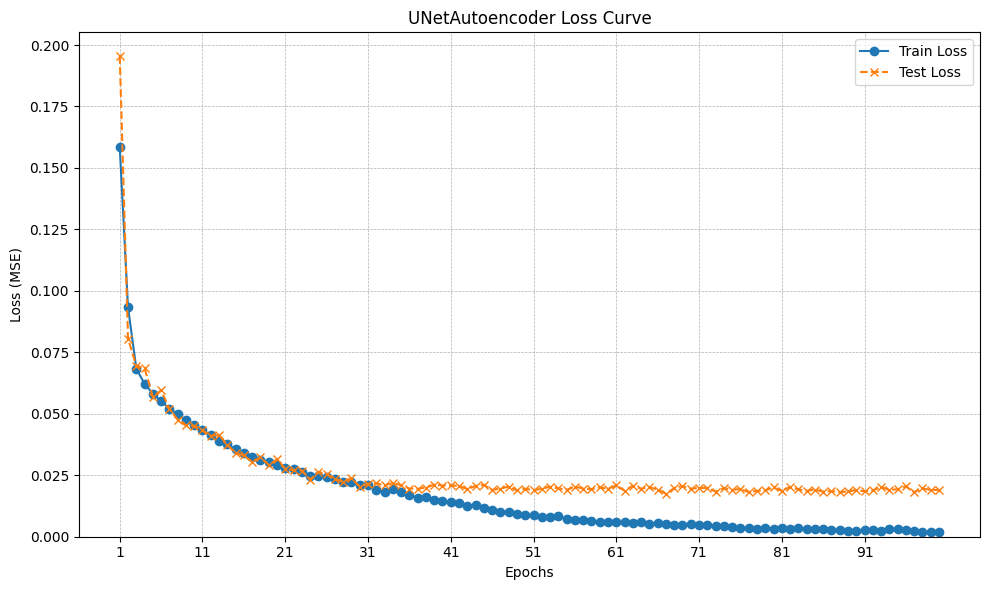


Visualizing results on device: cpu


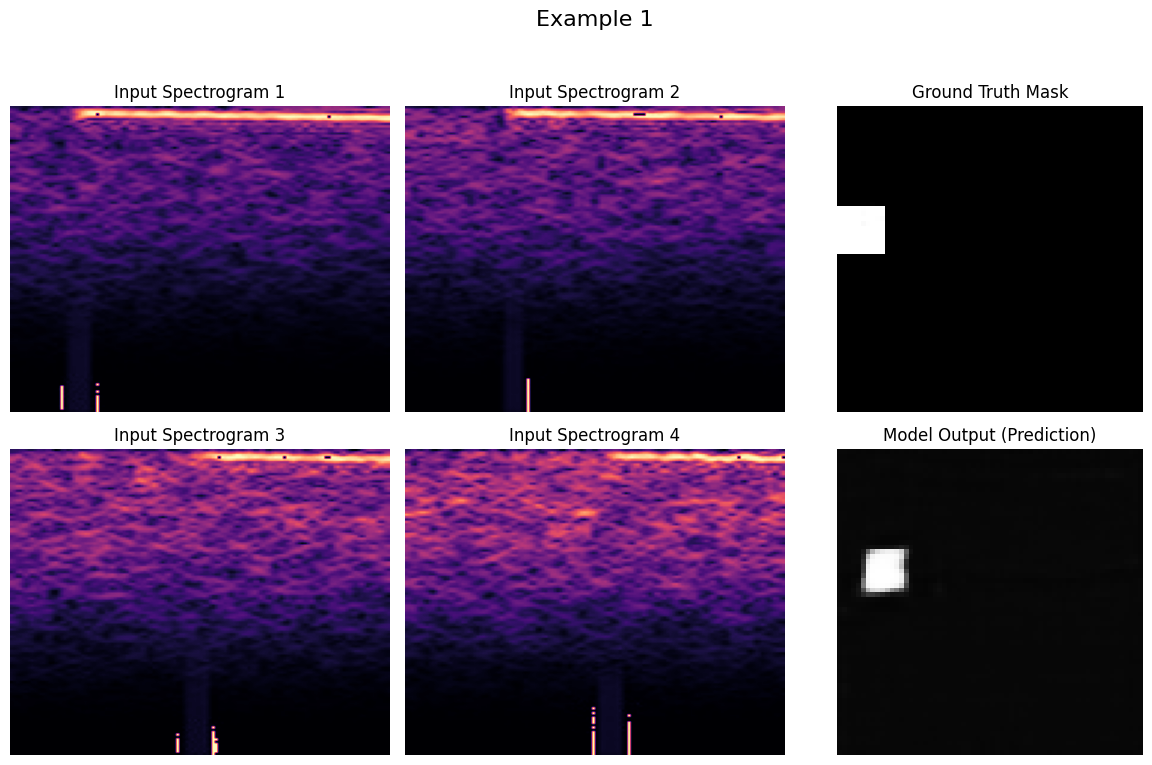

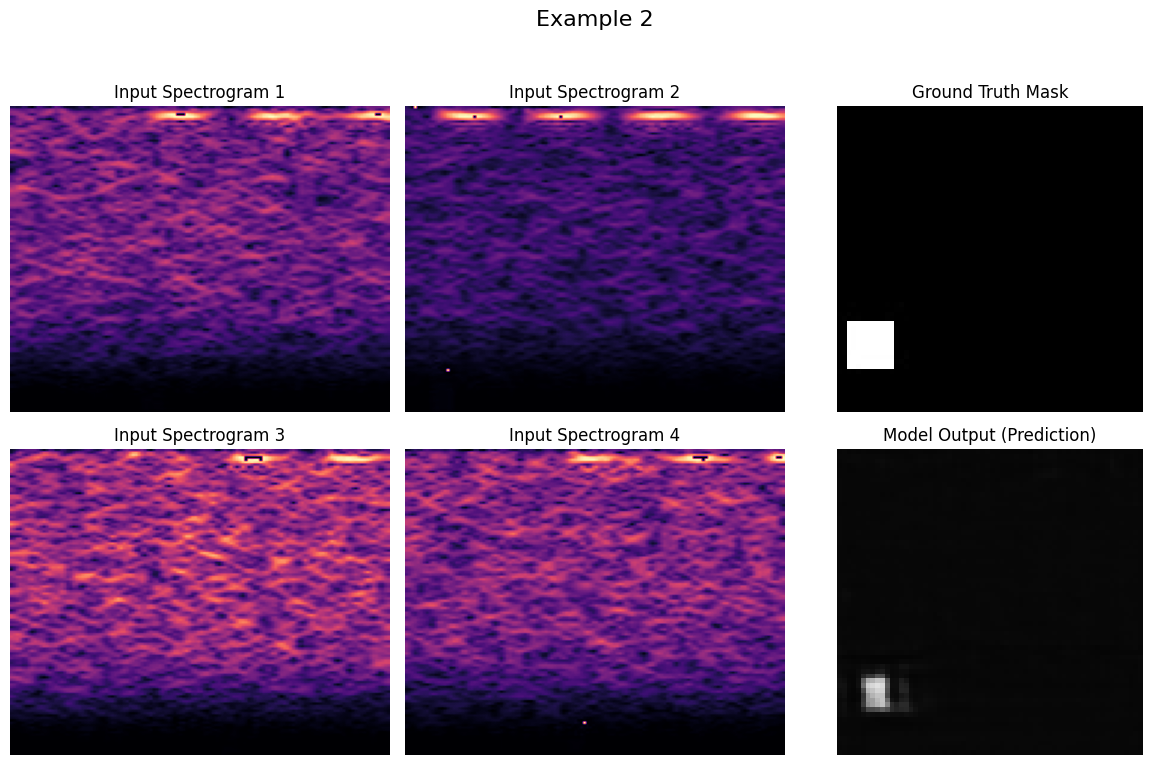

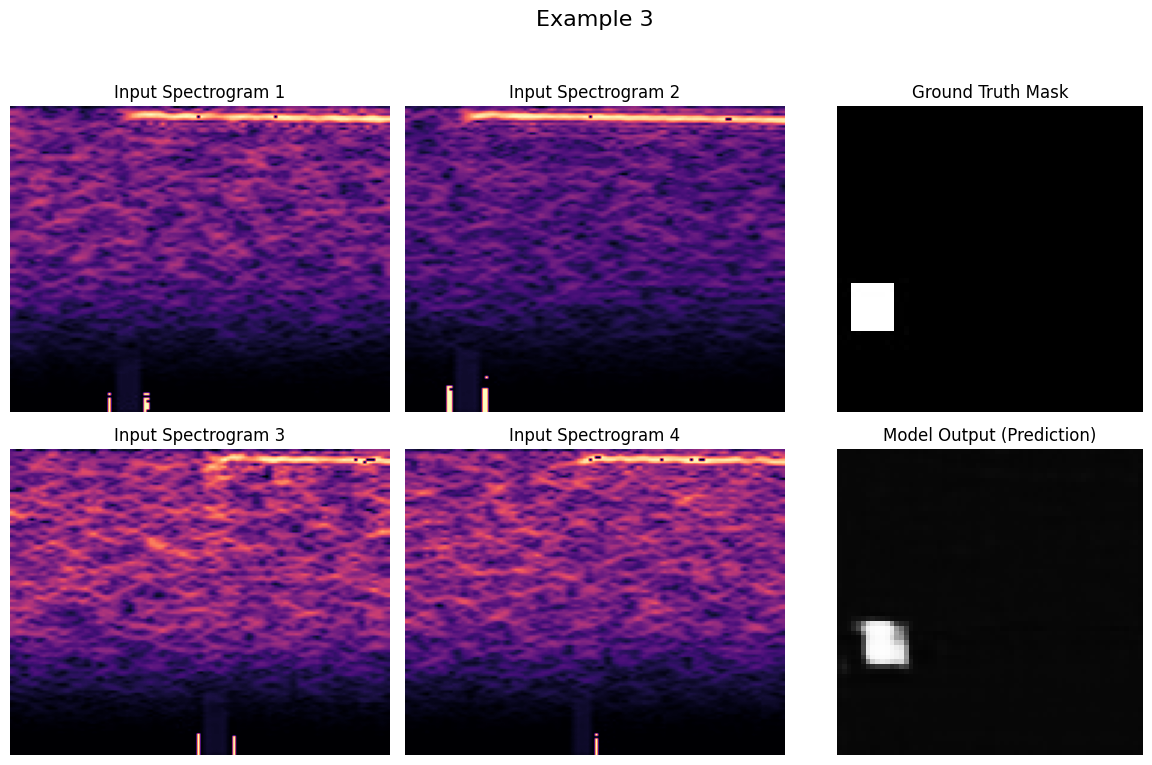

Visualization complete.


In [20]:
print(f"\n--- Results for Model 1: {MODEL_NAME_1} ---")

# Check if results exist before plotting/visualizing
if 'model_1_results' in locals() and model_1_results is not None:
    # Plot Loss Curve
    plot_loss_curve(model_1_results, title=f"{MODEL_NAME_1} Loss Curve")

    # Visualize Predictions (if dataloaders are available)
    if test_dataloader_small:
        visualize_results(
            model=model_1, # Use the model currently in memory
            test_loader=test_dataloader_small,
            num_examples=3
        )
    else:
        print("Test dataloader not available, skipping prediction visualization.")
else:
    print("Model 1 results are not available.")

In [21]:
# Display Model Summary (requires model_1 to be loaded or still in memory)
print(f"\n--- Model Summary for: {MODEL_NAME_1} ---")
if 'model_1' in locals():
    try:
        # Assuming input shape [Batch=1, Channels=4, Height=128, Width=128]
        model_1_summary = summary(
            model=model_1,
            input_size=(1, 4, 128, 128),
            col_names=["input_size", "output_size", "num_params", "mult_adds"],
            verbose=0 # 0 for brief, 1 for detailed
        )
        print(model_1_summary)
    except Exception as e:
        print(f"Could not generate summary for Model 1: {e}")
else:
    print("Model 1 not available in memory for summary.")



--- Model Summary for: UNetAutoencoder ---
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
UNetAutoencoder                          [1, 4, 128, 128]          [1, 1, 64, 64]            --                        --
├─Sequential: 1-1                        [1, 4, 128, 128]          [1, 32, 128, 128]         --                        --
│    └─Conv2d: 2-1                       [1, 4, 128, 128]          [1, 32, 128, 128]         1,152                     18,874,368
│    └─BatchNorm2d: 2-2                  [1, 32, 128, 128]         [1, 32, 128, 128]         64                        64
│    └─ReLU: 2-3                         [1, 32, 128, 128]         [1, 32, 128, 128]         --                        --
│    └─Conv2d: 2-4                       [1, 32, 128, 128]         [1, 32, 128, 128]         9,216                     150,994,944
│    └─BatchNorm2d: 2-5                  [1, 32, 128, 128]         [1, 32, 128

### 8.2. `UNetPPAutoencoder` (Model 2) Results


--- Results for Model 2: UNetPPAutoencoder ---


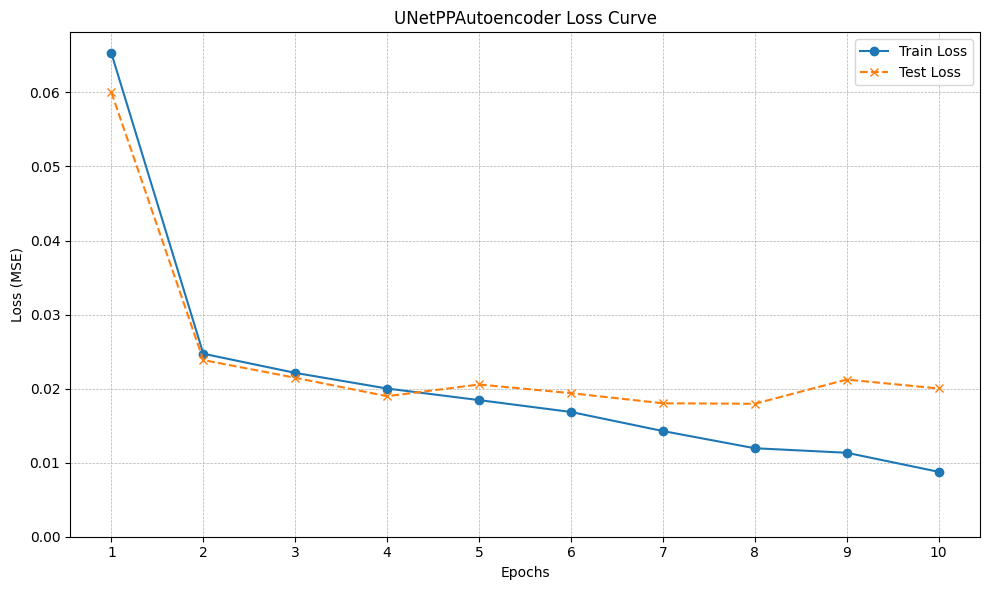


Visualizing results on device: cpu


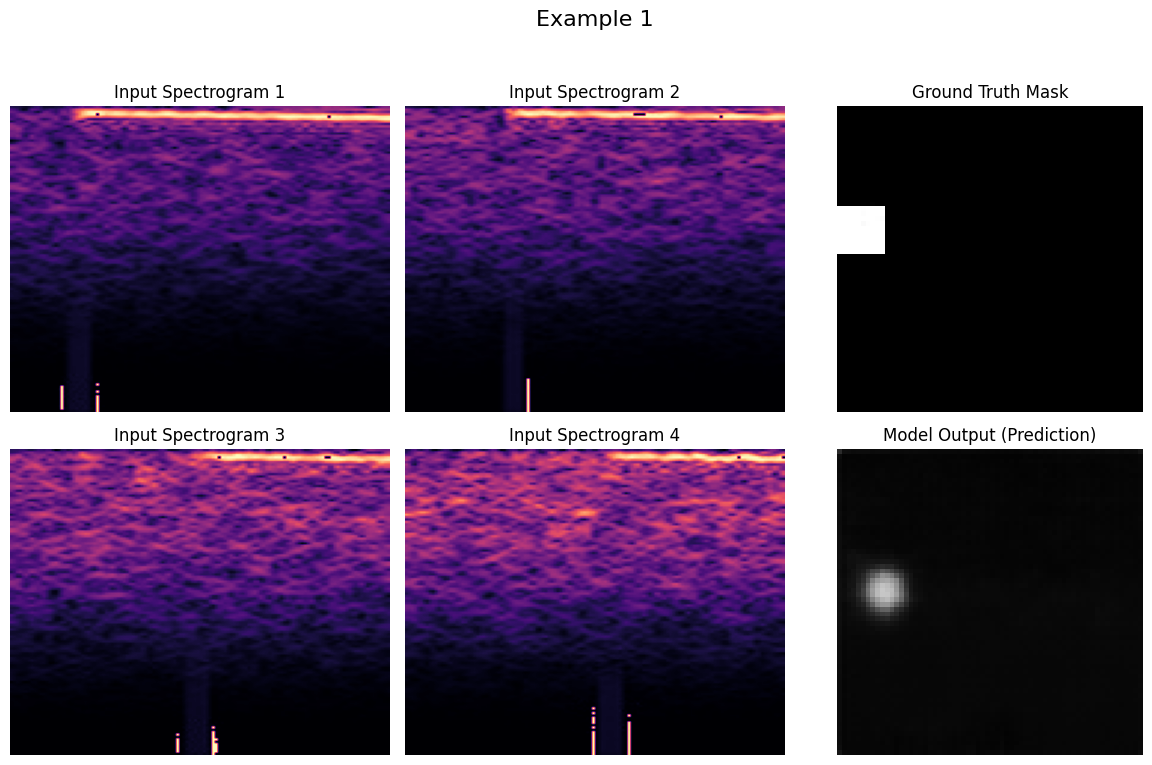

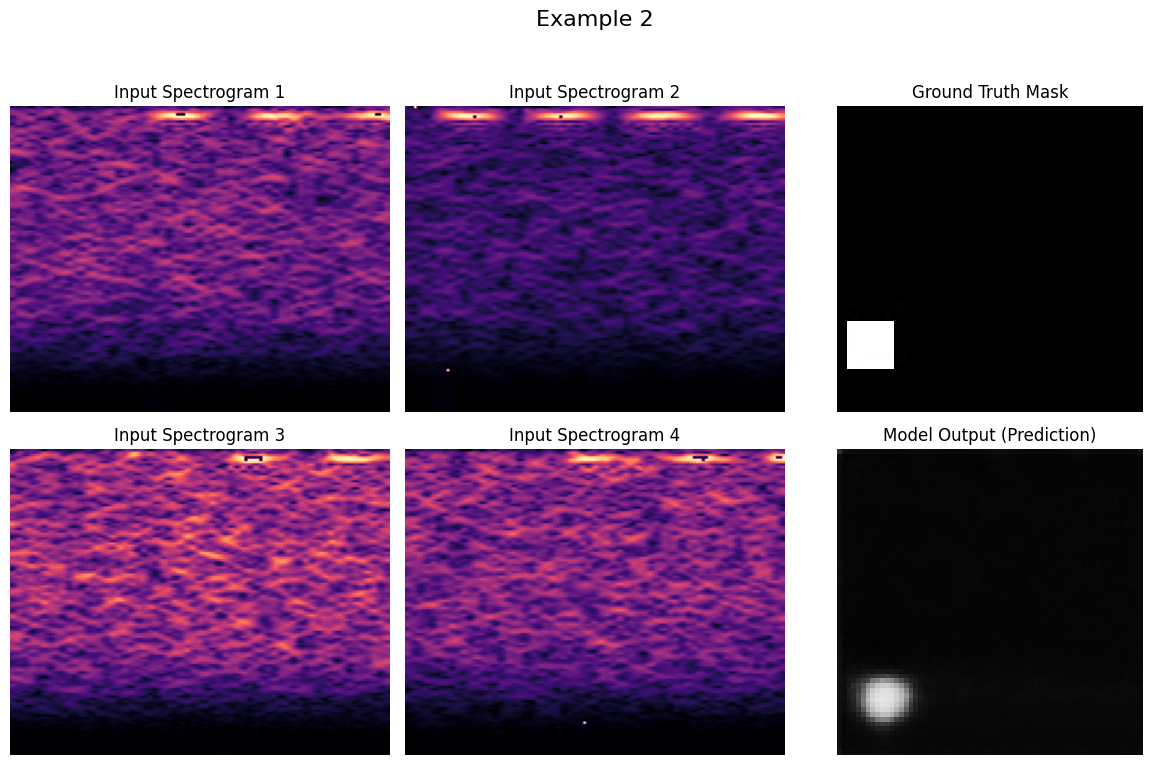

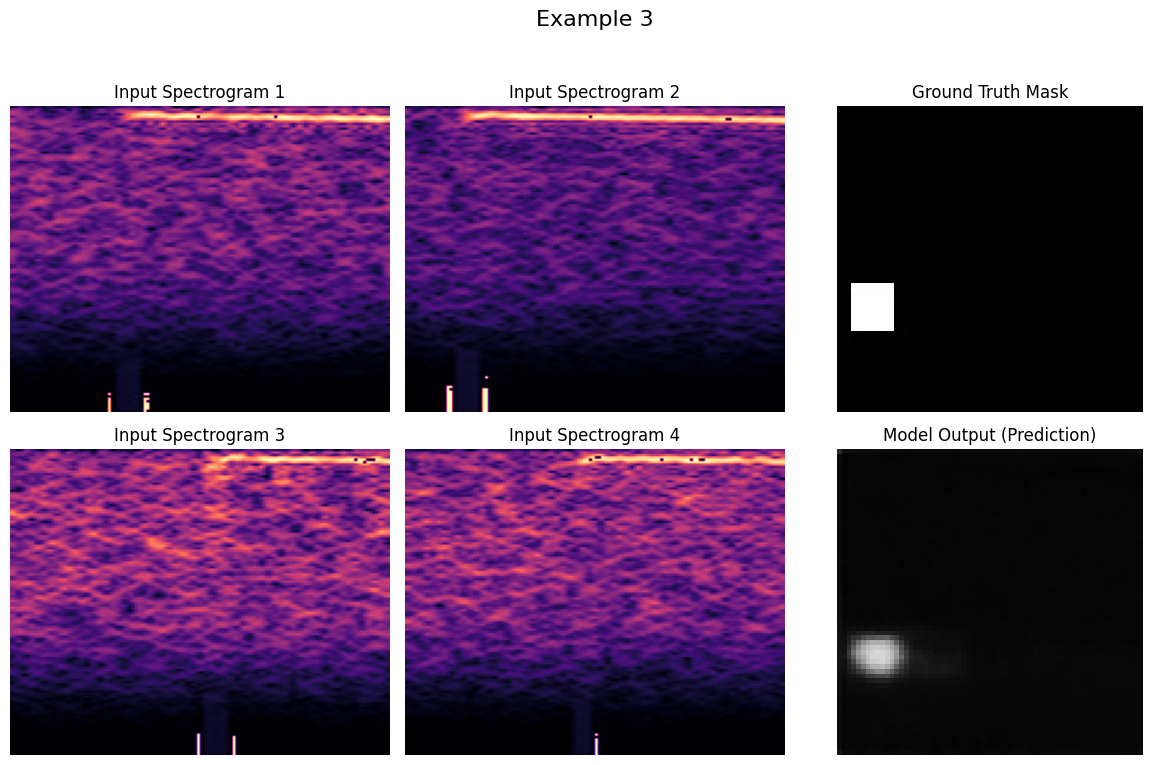

Visualization complete.


In [22]:
print(f"\n--- Results for Model 2: {MODEL_NAME_2} ---")

if 'model_2_results' in locals() and model_2_results is not None:
    # Plot Loss Curve
    plot_loss_curve(model_2_results, title=f"{MODEL_NAME_2} Loss Curve")

    # Visualize Predictions
    if test_dataloader_small:
        visualize_results(
            model=model_2,
            test_loader=test_dataloader_small,
            num_examples=3
        )
    else:
        print("Test dataloader not available, skipping prediction visualization.")
else:
    print("Model 2 results are not available.")

In [23]:
# Display Model Summary
print(f"\n--- Model Summary for: {MODEL_NAME_2} ---")
if 'model_2' in locals():
    try:
        model_2_summary = summary(
            model=model_2,
            input_size=(1, 4, 128, 128),
            col_names=["input_size", "output_size", "num_params", "mult_adds"],
            verbose=0
        )
        print(model_2_summary)
    except Exception as e:
        print(f"Could not generate summary for Model 2: {e}")
else:
    print("Model 2 not available in memory for summary.")


--- Model Summary for: UNetPPAutoencoder ---
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
UNetPPAutoencoder                        [1, 4, 128, 128]          [1, 1, 64, 64]            --                        --
├─ConvBlock: 1-1                         [1, 4, 128, 128]          [1, 32, 128, 128]         --                        --
│    └─Sequential: 2-1                   [1, 4, 128, 128]          [1, 32, 128, 128]         --                        --
│    │    └─Conv2d: 3-1                  [1, 4, 128, 128]          [1, 32, 128, 128]         1,152                     18,874,368
│    │    └─BatchNorm2d: 3-2             [1, 32, 128, 128]         [1, 32, 128, 128]         64                        64
│    │    └─ReLU: 3-3                    [1, 32, 128, 128]         [1, 32, 128, 128]         --                        --
│    │    └─Conv2d: 3-4                  [1, 32, 128, 128]         [1, 32, 128, 128] 